In [1]:
from edc import print_info
print_info("sh-xcube-integration")


***Notebook Title***  
Sentinel Hub - XCUBE integration

***Notebook Description***  
Euro Data Cube Sentinel Hub - XCUBE integration


***Notebook Dependencies***  
This notebook requires an active subscription to:
* EDC Sentinel Hub


In [2]:
from edc import check_compatibility
check_compatibility("user-0.24.5", dependencies=["SH"])



---------

The following environment variables are available:

* `SH_CLIENT_ID`, `SH_INSTANCE_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`


## EDC Sentinel Hub - XCUBE integration

This notebook demonstrates the deep integration between Sentinel Hub and the xcube 

1. On-the-fly access to any SentinelHub datasets
2. Utilising band / flag mask information
3. Utilising external vector / feature data
4. Persisting data cube's in user's workspace
5. Using Xcube Viewer to visualize generated cubes

In [3]:
# xcube_sh imports
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.observers import Observers
from xcube_sh.viewer import ViewerServer

# xcube imports
from xcube.core.maskset import MaskSet
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.geom import clip_dataset_by_geometry

# Various utilities
import json
import numpy as np
import xarray as xr
import shapely.geometry
import IPython.display
import zarr

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

---
For this demo, we are focussing on small coastal area near Kiel in Northern Germany (Baltic Sea)

In [5]:
x1 = 10.00  # degree
y1 = 54.27  # degree
x2 = 11.00  # degree
y2 = 54.60  # degree

bbox = x1, y1, x2, y2

In [6]:
#IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

Later in this NB we are going to compute some indexes from bands atmospherically corrected bands B04, B05, B06, B11 of Sentinel-2 (S2L2A)
Our time range covers two and a half month of last year's summer: 2018-05-14 to 2018-07-31

The desired resolution is roughly 20 meters per pixel:

In [7]:
spatial_res = 0.00018   # = 20.038 meters in degree>

---
Example (!): Sentinel-2 L2A with aggregated observations that fall into equal-size `time_period` of 2 days:

In [8]:
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B04', 'B05', 'B06', 'B11', 'SCL', 'CLD'],
                         tile_size=[512, 512],
                         geometry=bbox,
                         spatial_res=spatial_res,
                         time_range=['2018-05-14', '2018-07-31'],
                         time_period='2D')

We define a `request_collector` as an observer for SH requests made, so we can show SH usage stats. This is a developer tool, useful for demonstration purposes too. **Otherwise, this is not needed.**

In [9]:
request_collector = Observers.request_collector()

Open a data cube:

In [10]:
cube = open_cube(cube_config, observer=request_collector)

In [11]:
cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 2048, lon: 5632, time: 40)
Coordinates:
  * lat        (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon        (lon) float64 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time       (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(40, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    CLD        (time, lat, lon) uint8 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SCL        (time, lat, lon) uint8 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2021-05-11T14:56:36.298711
    time_coverage_start:       2018-05-14T00:00:00+00:00
    time_coverage_end:         2018-08-02T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P2DT0H0M0S
    geospatial_lon_min:        10.0
    geospatial_lat_min:        54.27
    geospatial_lon_max:        11.01376
    geospatial_lat_max:        54.63864
    processing_level:          L2A

Note: a data cube equivalent to `cube` can be generated persistently using the following CLI command: 

```bash
$ xcsh cubify S2L1C -o cube.zarr -b B08 -g 10.237174,53.506205,10.271174,53.540205 -r 6.640625e-05 -t 2017-08-01,2017-08-31 -p 1D
$ python 
>>> import xarray as xr
>>> cube = xr.open_zarr('cube.zarr')
>>> cube
```

In [12]:
cube.time

<xarray.DataArray 'time' (time: 40)>
array(['2018-05-15T00:00:00.000000000', '2018-05-17T00:00:00.000000000',
       '2018-05-19T00:00:00.000000000', '2018-05-21T00:00:00.000000000',
       '2018-05-23T00:00:00.000000000', '2018-05-25T00:00:00.000000000',
       '2018-05-27T00:00:00.000000000', '2018-05-29T00:00:00.000000000',
       '2018-05-31T00:00:00.000000000', '2018-06-02T00:00:00.000000000',
       '2018-06-04T00:00:00.000000000', '2018-06-06T00:00:00.000000000',
       '2018-06-08T00:00:00.000000000', '2018-06-10T00:00:00.000000000',
       '2018-06-12T00:00:00.000000000', '2018-06-14T00:00:00.000000000',
       '2018-06-16T00:00:00.000000000', '2018-06-18T00:00:00.000000000',
       '2018-06-20T00:00:00.000000000', '2018-06-22T00:00:00.000000000',
       '2018-06-24T00:00:00.000000000', '2018-06-26T00:00:00.000000000',
       '2018-06-28T00:00:00.000000000', '2018-06-30T00:00:00.000000000',
       '2018-07-02T00:00:00.000000000', '2018-07-04T00:00:00.000000000',
       '2018-07-06T00:00:00.000000000', '2018-07-08T00:00:00.000000000',
       '2018-07-10T00:00:00.000000000', '2018-07-12T00:00:00.000000000',
       '2018-07-14T00:00:00.000000000', '2018-07-16T00:00:00.000000000',
       '2018-07-18T00:00:00.000000000', '2018-07-20T00:00:00.000000000',
       '2018-07-22T00:00:00.000000000', '2018-07-24T00:00:00.000000000',
       '2018-07-26T00:00:00.000000000', '2018-07-28T00:00:00.000000000',
       '2018-07-30T00:00:00.000000000', '2018-08-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
Attributes:
    standard_name:  time
    bounds:         time_bnds

No requests have been made yet. Requests are made only if data is actually required.

In [13]:
request_collector.stats

Band metadata also comprises wavelength info:

In [14]:
cube.B04

,Array,Chunk
Bytes,1.72 GiB,1.00 MiB
Shape,"(40, 2048, 5632)","(1, 512, 512)"
Count,1761 Tasks,1760 Chunks
Type,float32,numpy.ndarray


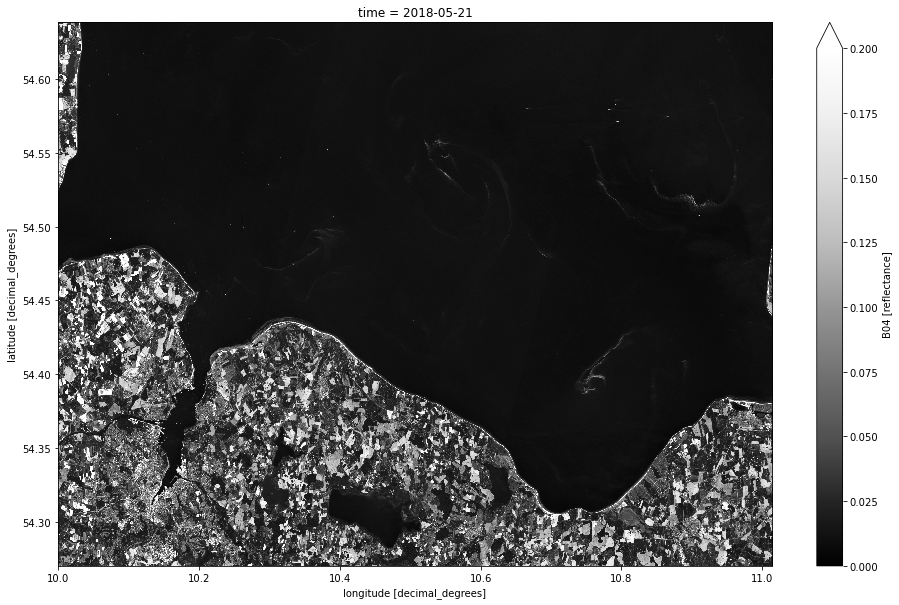

In [15]:
# SH requests
cube.B04.sel(time='2018-05-21 10:00:00', method='nearest').plot.imshow(vmin=0, vmax=0.2, cmap='Greys_r', figsize=(16, 10))

Now SentinelHub data requests have been made

In [16]:
request_collector.stats

Number of requests:,44
Request duration min:,318.84 ms
Request duration max:,2260.37 ms
Request duration median:,564.77 ms
Request duration mean:,662.97 ms
Request duration std:,349.70 ms


Scene classification flags have CF-conformant flag encoding information, which xcube can decode

In [17]:
cube.SCL

,Array,Chunk
Bytes,440.00 MiB,256.00 kiB
Shape,"(40, 2048, 5632)","(1, 512, 512)"
Count,1761 Tasks,1760 Chunks
Type,uint8,numpy.ndarray


In [18]:
import xcube.core.maskset as maskset

scene_classif = maskset.MaskSet(cube.SCL)
print(scene_classif)

SCL(no_data=(None, 0), saturated_or_defective=(None, 1), dark_area_pixels=(None, 2), cloud_shadows=(None, 3), vegetation=(None, 4), bare_soils=(None, 5), water=(None, 6), clouds_low_probability_or_unclassified=(None, 7), clouds_medium_probability=(None, 8), clouds_high_probability=(None, 9), cirrus=(None, 10), snow_or_ice=(None, 11))


xcube mask sets also follow data cube structure:

In [19]:
scene_classif.water

,Array,Chunk
Bytes,440.00 MiB,256.00 kiB
Shape,"(40, 2048, 5632)","(1, 512, 512)"
Count,8802 Tasks,1760 Chunks
Type,uint8,numpy.ndarray


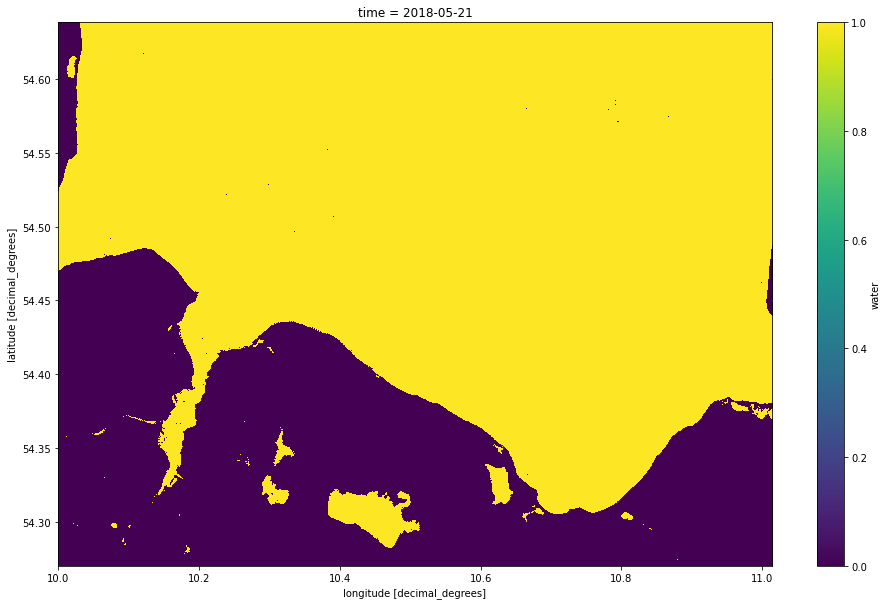

In [20]:
# SH requests
scene_classif.water.sel(time='2018-05-21').plot.imshow(figsize=(16, 10))

In [21]:
request_collector.stats

Number of requests:,88
Request duration min:,187.91 ms
Request duration max:,2260.37 ms
Request duration median:,412.26 ms
Request duration mean:,503.06 ms
Request duration std:,308.44 ms


We can use any of the mask or combinations of it to mask entire cubes. Here we create a "water cube":

In [22]:
water_cube = cube.where(scene_classif.water)
water_cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 2048, lon: 5632, time: 40)
Coordinates:
  * lat        (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon        (lon) float64 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time       (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(40, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    CLD        (time, lat, lon) float64 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SCL        (time, lat, lon) float64 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2021-05-11T14:56:36.298711
    time_coverage_start:       2018-05-14T00:00:00+00:00
    time_coverage_end:         2018-08-02T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P2DT0H0M0S
    geospatial_lon_min:        10.0
    geospatial_lat_min:        54.27
    geospatial_lon_max:        11.01376
    geospatial_lat_max:        54.63864
    processing_level:          L2A

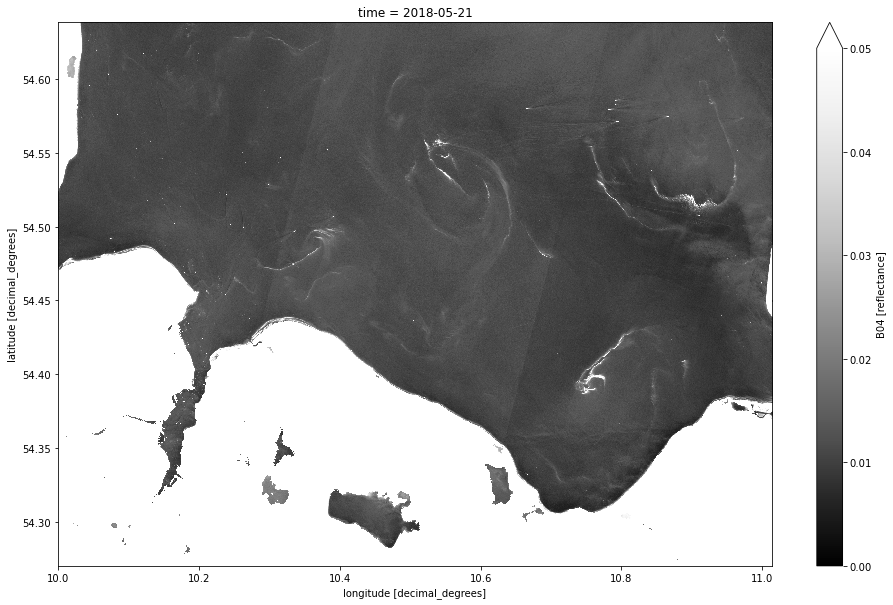

In [23]:
# SH requests
water_cube.B04.sel(time='2018-05-21').plot.imshow(vmin=0, vmax=0.05, cmap='Greys_r', figsize=(16, 10))

In [24]:
request_collector.stats

Number of requests:,88
Request duration min:,187.91 ms
Request duration max:,2260.37 ms
Request duration median:,412.26 ms
Request duration mean:,503.06 ms
Request duration std:,308.44 ms


---

We now compute a Chlorophyll indicator called *Maximum Chlorophyll Index* from bands B04, B05, B06:

In [25]:
b_from = water_cube.B04
b_peek = water_cube.B05
b_to = water_cube.B06

wlen_from = b_from.attrs['wavelength']
wlen_peek = b_peek.attrs['wavelength']
wlen_to = b_to.attrs['wavelength']

f = (wlen_peek - wlen_from) / (wlen_to - wlen_from)
mci = (b_peek - b_from) - f * (b_to - b_from)

mci.attrs['long_name'] = 'Maximum Chlorophyll Index'
mci.attrs['units'] = 'unitless'
mci

,Array,Chunk
Bytes,1.72 GiB,1.00 MiB
Shape,"(40, 2048, 5632)","(1, 512, 512)"
Count,26405 Tasks,1760 Chunks
Type,float32,numpy.ndarray


---

And the well-known *Normalised Difference Vegetation Index*:

In [26]:
veg_cube = cube.where(scene_classif.vegetation)
veg_cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 2048, lon: 5632, time: 40)
Coordinates:
  * lat        (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon        (lon) float64 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time       (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(40, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    CLD        (time, lat, lon) float64 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SCL        (time, lat, lon) float64 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2021-05-11T14:56:36.298711
    time_coverage_start:       2018-05-14T00:00:00+00:00
    time_coverage_end:         2018-08-02T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P2DT0H0M0S
    geospatial_lon_min:        10.0
    geospatial_lat_min:        54.27
    geospatial_lon_max:        11.01376
    geospatial_lat_max:        54.63864
    processing_level:          L2A

In [27]:
b_red = veg_cube.B04
b_nir = veg_cube.B11
ndvi = (b_nir - b_red) / (b_nir + b_red)
ndvi.attrs['long_name'] = 'Normalized Difference Vegetation Index'
ndvi.attrs['units'] = 'unitless'
ndvi

,Array,Chunk
Bytes,1.72 GiB,1.00 MiB
Shape,"(40, 2048, 5632)","(1, 512, 512)"
Count,21124 Tasks,1760 Chunks
Type,float32,numpy.ndarray


In [28]:
my_cube = xr.Dataset({'mci': mci, 'ndvi': ndvi})
my_cube

,Array,Chunk
Bytes,1.72 GiB,1.00 MiB
Shape,"(40, 2048, 5632)","(1, 512, 512)"
Count,26405 Tasks,1760 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.72 GiB,1.00 MiB
Shape,"(40, 2048, 5632)","(1, 512, 512)"
Count,21124 Tasks,1760 Chunks
Type,float32,numpy.ndarray


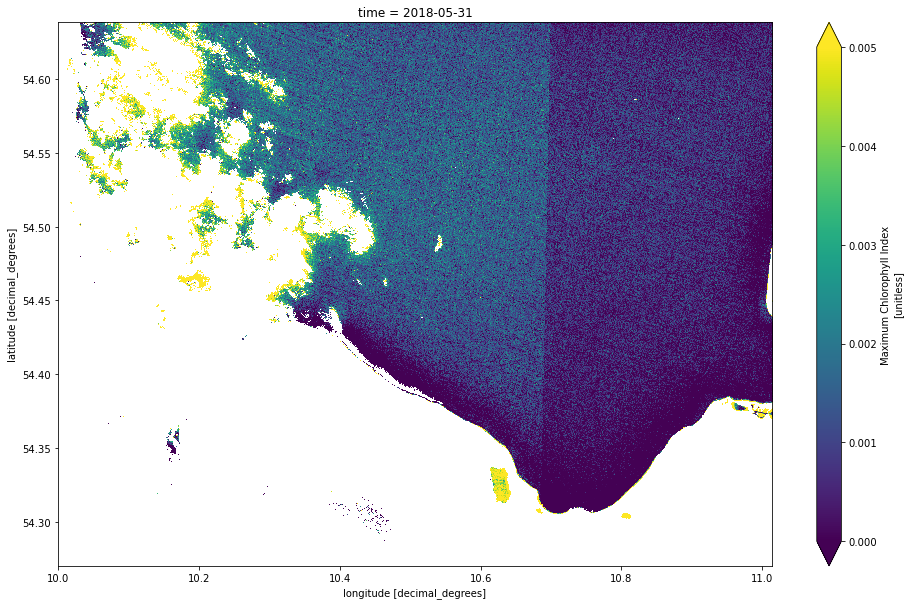

In [29]:
# Plot mci index
my_cube.mci.isel(time=8).plot.imshow(vmin=0, vmax=0.005, cmap='viridis', figsize=(16, 10))

In [30]:
request_collector.stats

Number of requests:,264
Request duration min:,187.91 ms
Request duration max:,2260.37 ms
Request duration median:,443.61 ms
Request duration mean:,494.57 ms
Request duration std:,247.15 ms
